In [15]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier

In [16]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'stroke_dataset_cleaned.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df = pd.read_csv(file_path)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,1,228.69,36.6,1,1,0,0
1,1,80.0,0,1,1,1,0,105.92,32.5,1,0,1,0
2,0,49.0,0,0,1,1,1,171.23,34.4,1,0,0,1
3,0,79.0,1,0,1,2,0,174.12,24.0,1,0,1,0
4,1,81.0,0,0,1,1,1,186.21,29.0,1,1,0,0


In [17]:
y = df['stroke']
X = df.drop(['stroke'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1337)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [18]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'random_seed': 42,
        'verbose': 0
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
    
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return sum(accuracies) / len(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

final_model = CatBoostClassifier(**best_params)
final_model.fit(X, y)

[I 2024-10-08 11:54:14,096] A new study created in memory with name: no-name-2a84113f-e838-4c44-9766-0461fe368b88
[I 2024-10-08 11:54:27,699] Trial 0 finished with value: 0.9319669364875095 and parameters: {'iterations': 670, 'learning_rate': 0.13620894436497996, 'depth': 5, 'l2_leaf_reg': 7.937980533392561, 'border_count': 144}. Best is trial 0 with value: 0.9319669364875095.
[I 2024-10-08 11:54:35,479] Trial 1 finished with value: 0.9306998886019799 and parameters: {'iterations': 228, 'learning_rate': 0.2175566093366493, 'depth': 8, 'l2_leaf_reg': 1.651816969991056e-05, 'border_count': 20}. Best is trial 0 with value: 0.9319669364875095.
[I 2024-10-08 11:54:45,330] Trial 2 finished with value: 0.9313331894140084 and parameters: {'iterations': 256, 'learning_rate': 0.17176422444205447, 'depth': 8, 'l2_leaf_reg': 0.000263940987112408, 'border_count': 16}. Best is trial 0 with value: 0.9319669364875095.
[W 2024-10-08 11:55:00,965] Trial 3 failed with parameters: {'iterations': 703, 'lea

KeyboardInterrupt: 

In [5]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

0:	learn: 0.5963772	total: 4.49ms	remaining: 449ms
1:	learn: 0.5201802	total: 5.57ms	remaining: 276ms
2:	learn: 0.4586705	total: 6.68ms	remaining: 218ms
3:	learn: 0.4075607	total: 19.6ms	remaining: 475ms
4:	learn: 0.3652634	total: 32ms	remaining: 614ms
5:	learn: 0.3294349	total: 44.8ms	remaining: 709ms
6:	learn: 0.2982563	total: 56.8ms	remaining: 762ms
7:	learn: 0.2712182	total: 68.8ms	remaining: 800ms
8:	learn: 0.2488155	total: 81.4ms	remaining: 832ms
9:	learn: 0.2298319	total: 95.4ms	remaining: 868ms
10:	learn: 0.2138377	total: 96.6ms	remaining: 790ms
11:	learn: 0.1988370	total: 109ms	remaining: 805ms
12:	learn: 0.1873831	total: 110ms	remaining: 743ms
13:	learn: 0.1748484	total: 121ms	remaining: 755ms
14:	learn: 0.1666138	total: 122ms	remaining: 701ms
15:	learn: 0.1562452	total: 134ms	remaining: 714ms
16:	learn: 0.1484918	total: 147ms	remaining: 725ms
17:	learn: 0.1393302	total: 158ms	remaining: 731ms
18:	learn: 0.1321726	total: 171ms	remaining: 737ms
19:	learn: 0.1264104	total: 183m

Precisión del modelo: 0.9636363636363636


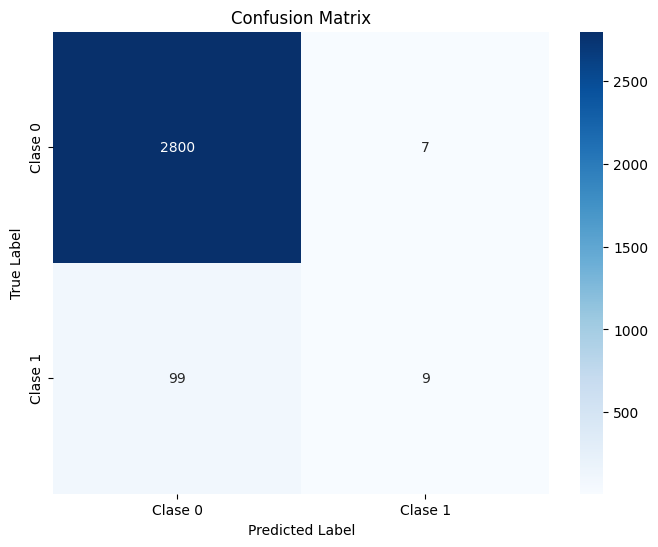

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2807
           1       0.56      0.08      0.15       108

    accuracy                           0.96      2915
   macro avg       0.76      0.54      0.56      2915
weighted avg       0.95      0.96      0.95      2915



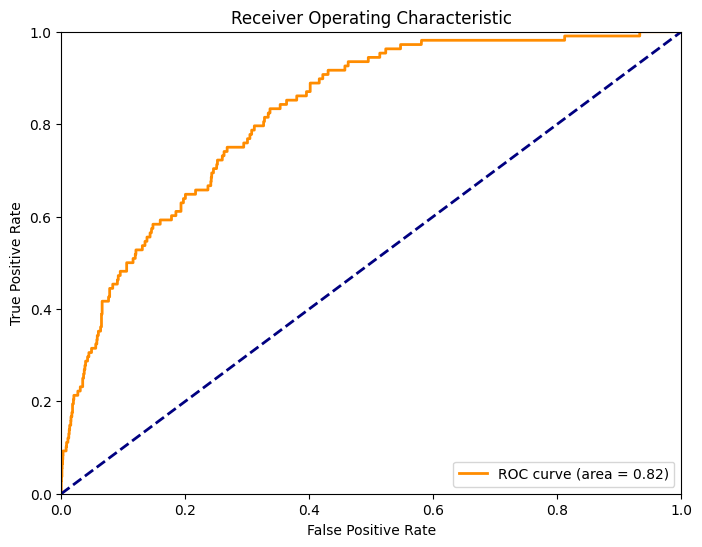

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()